In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle as pkl
import tensorflow as tf
import pandas as pd
import numpy as np
import math
import os
import numpy.linalg as la
from input_data import preprocess_data,load_sz_data,load_los_data
from tgcn import tgcnCell

from visualization import plot_result,plot_error
from sklearn.metrics import mean_squared_error,mean_absolute_error
#import matplotlib.pyplot as plt
import time


In [3]:
!which python

/Users/dacostlu/miniconda3/envs/T-GCN/bin/python


In [4]:
def TGCN(_X, _weights, _biases):
    ###
    cell_1 = tgcnCell(gru_units, adj, num_nodes=num_nodes)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell_1], state_is_tuple=True)
    _X = tf.unstack(_X, axis=1)
    outputs, states = tf.nn.static_rnn(cell, _X, dtype=tf.float32)
    m = []
    for i in outputs:
        o = tf.reshape(i, shape=[-1, num_nodes, gru_units])
        o = tf.reshape(o, shape=[-1, gru_units])
        m.append(o)
    last_output = m[-1]
    output = tf.matmul(last_output, _weights['out']) + _biases['out']
    output = tf.reshape(output, shape=[-1, num_nodes, pre_len])
    output = tf.transpose(output, perm=[0, 2, 1])
    output = tf.reshape(output, shape=[-1, num_nodes])
    return output, m, states


def evaluation(a,b):
    rmse = math.sqrt(mean_squared_error(a,b))
    mae = mean_absolute_error(a, b)
    F_norm = la.norm(a-b,'fro')/la.norm(a,'fro')
    r2 = 1-((a-b)**2).sum()/((a-a.mean())**2).sum()
    var = 1-(np.var(a-b))/np.var(a)
    return rmse, mae, 1-F_norm, r2, var




In [5]:
####Delete all flags before declare#####

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)



In [27]:
del_all_flags(tf.flags.FLAGS)

flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.001, 'Initial learning rate.')
flags.DEFINE_integer('training_epoch', 1, 'Number of epochs to train.')
flags.DEFINE_integer('gru_units', 64, 'hidden units of gru.')
flags.DEFINE_integer('seq_len',12 , '  time length of inputs.')
flags.DEFINE_integer('pre_len', 3, 'time length of prediction.')
flags.DEFINE_float('train_rate', 0.8, 'rate of training set.')
flags.DEFINE_integer('batch_size', 32, 'batch size.')
flags.DEFINE_string('dataset', 'los', 'sz or los.')
flags.DEFINE_string('model_name', 'tgcn', 'tgcn')
flags.DEFINE_string('f', '', 'kernel')  # see https://github.com/tensorflow/tensorflow/issues/17702#issuecomment-387335646


In [32]:
FLAGS.training_epoch = 10  # an epoch is about 20 seconds long

'bla'

In [29]:
tf.reset_default_graph()

time_start = time.time()
###### Settings ######
model_name = FLAGS.model_name
data_name = FLAGS.dataset
train_rate =  FLAGS.train_rate
seq_len = FLAGS.seq_len
output_dim = pre_len = FLAGS.pre_len
batch_size = FLAGS.batch_size
lr = FLAGS.learning_rate
training_epoch = FLAGS.training_epoch
gru_units = FLAGS.gru_units

###### load data ######
if data_name == 'sz':
    data, adj = load_sz_data('sz')
elif data_name == 'los':
    data, adj = load_los_data('los')
else:
    raise RuntimeError("data_name has to be 'sz' or 'los' (currently: %s)" % (data_name))

time_len = data.shape[0]
num_nodes = data.shape[1]
data1 = np.mat(data,dtype=np.float32)

#### normalization
max_value = np.max(data1)
data1  = data1/max_value
trainX, trainY, testX, testY = preprocess_data(data1, time_len, train_rate, seq_len, pre_len)

totalbatch = int(trainX.shape[0]/batch_size)
training_data_count = len(trainX)


###### placeholders ######
inputs = tf.placeholder(tf.float32, shape=[None, seq_len, num_nodes])
labels = tf.placeholder(tf.float32, shape=[None, pre_len, num_nodes])

# Graph weights
weights = {
    'out': tf.Variable(tf.random_normal([gru_units, pre_len], mean=1.0), name='weight_o')}
biases = {
    'out': tf.Variable(tf.random_normal([pre_len]),name='bias_o')}

if model_name.upper() != 'TGCN':
    raise RuntimeError("Model name has to be 'tgcn' (currently: %s)" % (model_name))
pred,ttts,ttto = TGCN(inputs, weights, biases)

y_pred = pred


###### optimizer ######
lambda_loss = 0.0015
Lreg = lambda_loss * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
label = tf.reshape(labels, [-1,num_nodes])
##loss
loss = tf.reduce_mean(tf.nn.l2_loss(y_pred-label) + Lreg)
##rmse
error = tf.sqrt(tf.reduce_mean(tf.square(y_pred-label)))
optimizer = tf.train.AdamOptimizer(lr).minimize(loss)

###### Initialize session ######
variables = tf.global_variables()
saver = tf.train.Saver(tf.global_variables())
#sess = tf.Session()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

out = 'out/%s'%(model_name)
#out = 'out/%s_%s'%(model_name,'perturbation')
path1 = '%s_%s_lr%r_batch%r_unit%r_seq%r_pre%r_epoch%r'%(model_name,data_name,lr,batch_size,gru_units,seq_len,pre_len,training_epoch)
path = os.path.join(out,path1)
if not os.path.exists(path):
    os.makedirs(path)

###### evaluation ######
x_axe,batch_loss,batch_rmse,batch_pred = [], [], [], []
test_loss,test_rmse,test_mae,test_acc,test_r2,test_var,test_pred = [],[],[],[],[],[],[]

test_label = np.reshape(testY, [-1, num_nodes])
test_label1 = test_label * max_value
for epoch in range(training_epoch):
    for m in range(totalbatch):
        mini_batch = trainX[m * batch_size : (m+1) * batch_size]
        mini_label = trainY[m * batch_size : (m+1) * batch_size]
        _, loss1, rmse1, train_output = sess.run([optimizer, loss, error, y_pred],
                                                 feed_dict = {inputs:mini_batch, labels:mini_label})
        batch_loss.append(loss1)
        batch_rmse.append(rmse1 * max_value)

     # Test completely at every epoch
    loss2, rmse2, test_output = sess.run([loss, error, y_pred],
                                         feed_dict = {inputs:testX, labels:testY})
    rmse, mae, acc, r2_score, var_score = evaluation(test_label, test_output)
    test_output1 = test_output * max_value
    test_loss.append(loss2)
    test_rmse.append(rmse * max_value)
    test_mae.append(mae * max_value)
    test_acc.append(acc)
    test_r2.append(r2_score)
    test_var.append(var_score)
    test_pred.append(test_output1)

    print('Iter:{}'.format(epoch),
          'train_rmse:{:.4}'.format(batch_rmse[-1]),
          'test_loss:{:.4}'.format(loss2),
          'test_rmse:{:.4}'.format(rmse),
          'test_acc:{:.4}'.format(acc))

    if (epoch % 500 == 0):
        saver.save(sess, path+'/model_100/TGCN_pre_%r'%epoch, global_step = epoch)

time_end = time.time()
print("Training finished in %.2f seconds" % (time_end-time_start))

Iter:0 train_rmse:9.59 test_loss:2.566e+03 test_rmse:0.1457 test_acc:0.8263
Iter:1 train_rmse:9.444 test_loss:2.307e+03 test_rmse:0.1382 test_acc:0.8353
Iter:2 train_rmse:8.929 test_loss:2.02e+03 test_rmse:0.1293 test_acc:0.8459
Iter:3 train_rmse:8.546 test_loss:1.843e+03 test_rmse:0.1235 test_acc:0.8528
Iter:4 train_rmse:8.266 test_loss:1.692e+03 test_rmse:0.1183 test_acc:0.859
Iter:5 train_rmse:8.064 test_loss:1.571e+03 test_rmse:0.114 test_acc:0.8641
Iter:6 train_rmse:7.912 test_loss:1.472e+03 test_rmse:0.1104 test_acc:0.8685
Iter:7 train_rmse:7.736 test_loss:1.385e+03 test_rmse:0.1071 test_acc:0.8724
Iter:8 train_rmse:7.561 test_loss:1.316e+03 test_rmse:0.1044 test_acc:0.8756
Iter:9 train_rmse:7.398 test_loss:1.262e+03 test_rmse:0.1022 test_acc:0.8782
Training finished in 217.27 seconds


Results written in 'out/tgcn/tgcn_los_lr0.001_batch32_unit64_seq12_pre3_epoch10/test_result.csv'
Figure saved as 'out/tgcn/tgcn_los_lr0.001_batch32_unit64_seq12_pre3_epoch10/test_all.png'


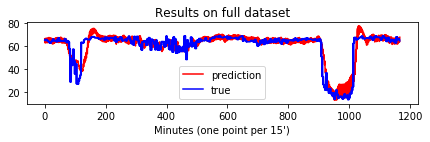

Figure saved as 'out/tgcn/tgcn_los_lr0.001_batch32_unit64_seq12_pre3_epoch10/test_oneday.png'


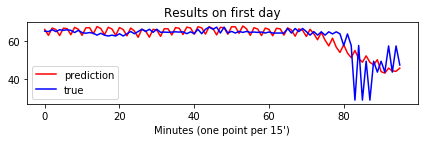

Figure saved as 'out/tgcn/tgcn_los_lr0.001_batch32_unit64_seq12_pre3_epoch10/rmse.png'


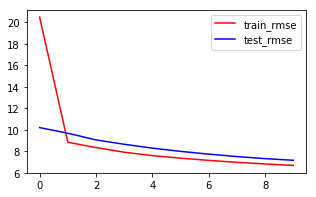

Figure saved as 'out/tgcn/tgcn_los_lr0.001_batch32_unit64_seq12_pre3_epoch10/train_loss.png'


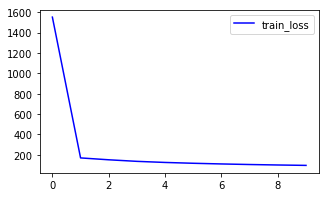

Figure saved as 'out/tgcn/tgcn_los_lr0.001_batch32_unit64_seq12_pre3_epoch10/train_rmse.png'


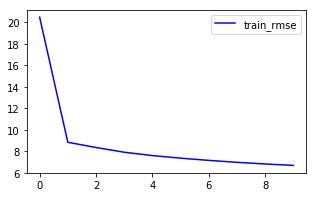

Figure saved as 'out/tgcn/tgcn_los_lr0.001_batch32_unit64_seq12_pre3_epoch10/test_acc.png'


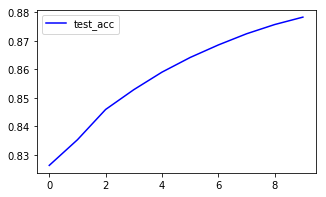

Figure saved as 'out/tgcn/tgcn_los_lr0.001_batch32_unit64_seq12_pre3_epoch10/test_rmse.png'


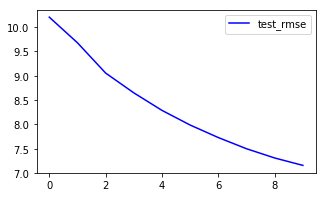

Figure saved as 'out/tgcn/tgcn_los_lr0.001_batch32_unit64_seq12_pre3_epoch10/test_mae.png'


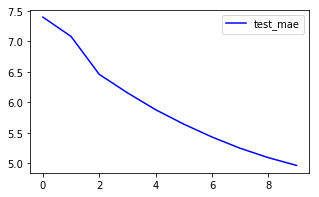

min_rmse:7.153556793782667 min_mae:4.966951 max_acc:0.8782186880707741 r2:0.7340003848075867 var:0.734005331993103


In [30]:
############## visualization ###############
b = int(len(batch_rmse)/totalbatch)
batch_rmse1 = [i for i in batch_rmse]
train_rmse = [(sum(batch_rmse1[i*totalbatch:(i+1)*totalbatch])/totalbatch) for i in range(b)]
batch_loss1 = [i for i in batch_loss]
train_loss = [(sum(batch_loss1[i*totalbatch:(i+1)*totalbatch])/totalbatch) for i in range(b)]

index = test_rmse.index(np.min(test_rmse))
test_result = test_pred[index]
var = pd.DataFrame(test_result)
output_csv = path+'/test_result.csv'
var.to_csv(output_csv, index = False,header = False)
print("Results written in '%s'" % (output_csv))
plot_result(test_result,test_label1,path)
plot_error(train_rmse,train_loss,test_rmse,test_acc,test_mae,path)

print('min_rmse:%r'%(np.min(test_rmse)),
      'min_mae:%r'%(test_mae[index]),
      'max_acc:%r'%(test_acc[index]),
      'r2:%r'%(test_r2[index]),
      'var:%r'%test_var[index])
